In [1]:
import ruptures as rpt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import StandardScaler
import pymc as pm
import arviz as az

/Users/sondosbsharat/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [30]:
def bayesian_cp_forecast(df, feature_cols):
    X = df[feature_cols].values
    y = df['y'].values
    n_obs, n_features = X.shape
    idx = np.arange(n_obs)

    with pm.Model() as model:
        # ----------------------------------------------------------------
        # Improved priors with better parameterization
        # ----------------------------------------------------------------
        # Regime coefficients with hierarchical structure
        alpha_mu = pm.Normal('alpha_mu', mu=0, sigma=1)
        alpha_delta = pm.Normal('alpha_delta', mu=0, sigma=0.5)
        alpha_0 = pm.Deterministic('alpha_0', alpha_mu - alpha_delta/2)
        alpha_1 = pm.Deterministic('alpha_1', alpha_mu + alpha_delta/2)
        
        # Non-centered parameterization for betas
        beta_scale = pm.HalfNormal('beta_scale', 1)
        beta_mu_raw = pm.Normal('beta_mu_raw', 0, 1, shape=n_features)
        beta_delta_raw = pm.Normal('beta_delta_raw', 0, 1, shape=n_features)
        
        beta_mu = pm.Deterministic('beta_mu', beta_mu_raw * beta_scale)
        beta_delta = pm.Deterministic('beta_delta', beta_delta_raw * beta_scale * 0.5)
        
        betas_0 = pm.Deterministic('betas_0', beta_mu - beta_delta)
        betas_1 = pm.Deterministic('betas_1', beta_mu + beta_delta)
        
        # More stable variance parameterization
        sigma_base = pm.Exponential('sigma_base', lam=20)
        sigma_ratio = pm.Beta('sigma_ratio', alpha=2, beta=2)  # Between 0 and 1
        
        sigma_0 = pm.Deterministic('sigma_0', sigma_base * (2 - sigma_ratio))
        sigma_1 = pm.Deterministic('sigma_1', sigma_base * sigma_ratio)
        
        # More informative prior for change point location
        tau_alpha = 2.0  # Concentration around the middle
        tau_beta = 2.0   # Concentration around the middle
        
        # Map to [0,1] then scale to observation range
        tau_loc = pm.Beta('tau_loc', alpha=tau_alpha, beta=tau_beta)
        tau_cont = pm.Deterministic('tau_cont', tau_loc * n_obs)
        
        # Better kappa (smoothness) parameterization - constrained to reasonable range
        kappa_gamma = pm.Gamma('kappa_gamma', alpha=3, beta=1)  # Shape and rate parameters
        kappa = pm.Deterministic('kappa', pm.math.clip(kappa_gamma, 1, 10))
        
        # ----------------------------------------------------------------
        # Transition weights with numerical stability
        # ----------------------------------------------------------------
        # Small epsilon to avoid numerical issues at the edges
        epsilon = 1e-6
        
        # Sigmoid transition with better numerical properties
        w_raw = (idx - tau_cont) / kappa
        w_t = pm.math.invlogit(w_raw)
        
        # Ensure weights are strictly between 0 and 1
        w_t_stable = w_t * (1 - 2*epsilon) + epsilon
        
        # ----------------------------------------------------------------
        # Mean and variance calculation
        # ----------------------------------------------------------------
        # Compute regime means
        mu0 = alpha_0 + pm.math.dot(X, betas_0)   # (n_obs,)
        mu1 = alpha_1 + pm.math.dot(X, betas_1)   # (n_obs,)
        
        # Mix means
        mu = (1 - w_t_stable) * mu0 + w_t_stable * mu1
        
        # Variance mixing in squared space (more stable)
        var_t = (1 - w_t_stable) * sigma_0**2 + w_t_stable * sigma_1**2
        sigma_t = pm.math.sqrt(var_t)
        
        # ----------------------------------------------------------------
        # Likelihood
        # ----------------------------------------------------------------
        y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma_t, observed=y)

           # record log‑likelihood for WAIC/LOO
        logp = pm.logp(y_obs, y)
        pm.Deterministic('log_likelihood', logp)
        
        # ----------------------------------------------------------------
        # Sampling with optimized settings
        # ----------------------------------------------------------------
        trace = pm.sample(
            draws=4000,
            tune=6000,
            chains=4,
            cores=4,
            target_accept=0.95,  # Less strict target_accept
            init="adapt_diag",   # More stable initialization
            return_inferencedata=True,
            idata_kwargs={"log_likelihood": True}
        )
        
        # Check convergence
        rhat_vals = az.rhat(trace)
        if not (rhat_vals < 1.01).all():
            print("⚠️ Warning: Some variables have r_hat > 1.01. Sampling might not have fully converged.")
        else:
            print("✅ Sampling looks good (r_hat < 1.01 for all variables).")

        # Enhanced diagnostics for remaining divergences
        div_mask = trace.sample_stats.diverging.values == 1
        div_count = div_mask.sum()
        print(f"Number of divergences: {div_count}")
        
        if div_count > 0:
            # Identify which parameters are associated with divergences
            print("\nDivergence analysis:")
            try:
                # Get the parameter values where divergences occurred
                for var in ['tau_cont', 'kappa', 'sigma_0', 'sigma_1']:
                    var_values = trace.posterior[var].values
                    div_values = var_values[div_mask]
                    print(f"{var} range at divergences: {div_values.min():.3f} to {div_values.max():.3f}")
                    print(f"{var} overall range: {var_values.min():.3f} to {var_values.max():.3f}")
            except:
                print("Could not analyze specific divergence locations.")
    
    # ----------------------------------------------------------------
    # Diagnostics
    # ----------------------------------------------------------------
    summary = az.summary(trace, var_names=['tau_cont','kappa','alpha_0','alpha_1','sigma_0','sigma_1'], 
                     hdi_prob=0.95)
    print(summary)
    
    # Create and show diagnostic plots
    try:
        import matplotlib.pyplot as plt
        
        # Plot change point distribution
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        az.plot_posterior(trace, var_names=['tau_cont'], ax=axes[0])
        axes[0].set_title('Change Point Location')
        
        # Plot transition smoothness
        az.plot_posterior(trace, var_names=['kappa'], ax=axes[1])
        axes[1].set_title('Transition Smoothness')
        
        plt.tight_layout()
        
        # Plot transition function for posterior mean
        tau_mean = trace.posterior.tau_cont.mean().item()
        kappa_mean = trace.posterior.kappa.mean().item()
        
        plt.figure(figsize=(10, 4))
        w_mean = 1/(1 + np.exp(-(idx - tau_mean) / kappa_mean))
        plt.plot(idx, w_mean)
        plt.axvline(tau_mean, color='red', linestyle='--', alpha=0.5, label=f'Change point: {tau_mean:.1f}')
        plt.title('Transition Function (Posterior Mean)')
        plt.xlabel('Observation Index')
        plt.ylabel('Weight of Regime 1')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        plt.tight_layout()
    except Exception as e:
        print(f"Could not create plots: {e}")    
            
        # Check for divergences
        div_count = (trace.sample_stats.diverging.values == 1).sum()
        print(f"Number of divergences: {div_count}")


        
    # ----------------------------------------------------------------
    # Diagnostics
    # ----------------------------------------------------------------
    print(az.summary(trace, var_names=['tau_cont','kappa','alpha_0','alpha_1','sigma_0','sigma_1'], 
                     hdi_prob=0.95))
    
    return model, trace



Function signature & docstring

Declares that we’ll infer one change-point (τ) and two sets of regression parameters.

X = df[feature_cols].values

Grabs your standardized predictors (lagged returns, VIX, sentiment features) as a NumPy array of shape (n_obs × n_features).

y = df['y'].values

Your target series: the next-day return at each time t.

n_obs, n_features = X.shape

Number of days (observations) and number of predictors.

idx = np.arange(n_obs)

Integer index array [0,1,2,…,n_obs−1] used to decide “which regime” each day belongs to relative to τ

In [7]:
df = pd.read_csv('../ready_Data/df_daily_last.csv')  # Has: date, title, descriptio
# feature_cols = ['ret_lag1','ret_roll5','vix_lag1','vix_chg1','sent_lag1','sent_roll3']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1908 entries, 0 to 1907
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     1908 non-null   object 
 1   date.1                   1908 non-null   object 
 2   close_sp500              1908 non-null   float64
 3   close_vix                1908 non-null   float64
 4   polarity_x_strong        1908 non-null   float64
 5   y                        1908 non-null   float64
 6   ret_lag1                 1908 non-null   float64
 7   ret_roll5                1908 non-null   float64
 8   vix_lag1                 1908 non-null   float64
 9   vix_chg1                 1908 non-null   float64
 10  polarity_x_strong_lag1   1908 non-null   float64
 11  polarity_x_strong_roll3  1908 non-null   float64
dtypes: float64(10), object(2)
memory usage: 179.0+ KB


In [8]:
# 1. Standardize (zero‐mean, unit‐std) each series so neither dominates
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['sent_roll3_std', 'vix_chg1_std']] = scaler.fit_transform(
    df[['polarity_x_strong_roll3', 'vix_chg1']]
)

# 2. Create the interaction (volatility‐weighted sentiment)
df['sent_vix'] = df['sent_roll3_std'] * df['vix_chg1_std']

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1908 entries, 0 to 1907
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     1908 non-null   object 
 1   date.1                   1908 non-null   object 
 2   close_sp500              1908 non-null   float64
 3   close_vix                1908 non-null   float64
 4   polarity_x_strong        1908 non-null   float64
 5   y                        1908 non-null   float64
 6   ret_lag1                 1908 non-null   float64
 7   ret_roll5                1908 non-null   float64
 8   vix_lag1                 1908 non-null   float64
 9   vix_chg1                 1908 non-null   float64
 10  polarity_x_strong_lag1   1908 non-null   float64
 11  polarity_x_strong_roll3  1908 non-null   float64
 12  sent_roll3_std           1908 non-null   float64
 13  vix_chg1_std             1908 non-null   float64
 14  sent_vix                

Training on 1526 rows, testing on 382 rows


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_mu, alpha_delta, beta_scale, beta_mu_raw, beta_delta_raw, sigma_base, sigma_ratio, tau_loc, kappa_gamma]


Sampling 4 chains for 6_000 tune and 4_000 draw iterations (24_000 + 16_000 draws total) took 1334 seconds.
There were 149 divergences after tuning. Increase `target_accept` or reparameterize.


✅ Sampling looks good (r_hat < 1.01 for all variables).
Number of divergences: 149

Divergence analysis:
tau_cont range at divergences: 277.731 to 296.988
tau_cont overall range: 261.226 to 334.507
kappa range at divergences: 1.000 to 10.000
kappa overall range: 1.000 to 10.000
sigma_0 range at divergences: 0.021 to 0.025
sigma_0 overall range: 0.020 to 0.028
sigma_1 range at divergences: 0.010 to 0.011
sigma_1 overall range: 0.010 to 0.012
             mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
tau_cont  288.303  4.098   279.206    295.713      0.047    0.033    9233.0   
kappa       2.951  1.873     1.000      6.840      0.020    0.014   10207.0   
alpha_0     0.002  0.001    -0.001      0.005      0.000    0.000    6022.0   
alpha_1     0.002  0.000     0.001      0.002      0.000    0.000   18853.0   
sigma_0     0.023  0.001     0.021      0.025      0.000    0.000   10144.0   
sigma_1     0.010  0.000     0.010      0.011      0.000    0.000   20388.0   

 

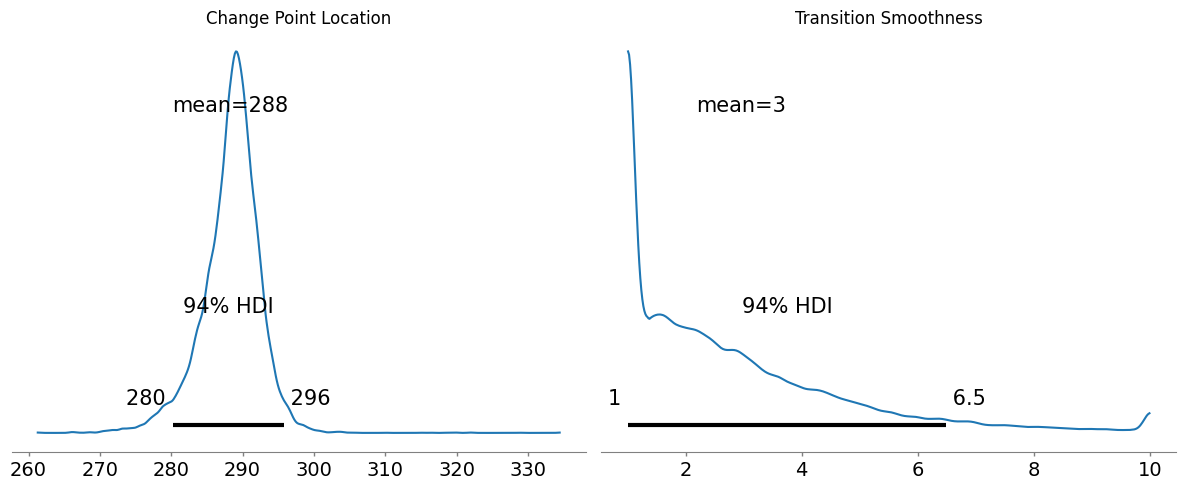

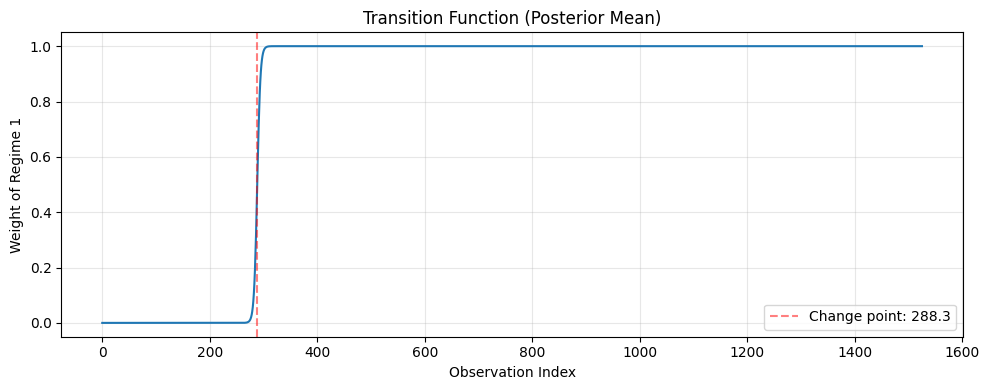

In [31]:

# =====================================================================
# SECTION 5: Evaluation & Baseline Comparison
# Compare against ARIMA/LSTM as described in proposal
# =====================================================================

# (Implement ARIMA, LSTM training and then compute MAE, RMSE, log-likelihood)

if __name__ == '__main__':
    n = len(df)
    split_idx = int(0.8 * n)

    df_train = df.iloc[:split_idx].copy()
    df_test  = df.iloc[split_idx:].copy()

    print(f"Training on {len(df_train)} rows, testing on {len(df_test)} rows")
    feature_cols = [
    'ret_lag1','ret_roll5','vix_lag1','vix_chg1']

    # 2) Fit your Bayesian change‐point model on df_train only
    model, trace = bayesian_cp_forecast(df_train,feature_cols)



In [32]:
import arviz as az
idata=trace
# Compute WAIC and LOO
waic_result = az.waic(idata)
loo_result = az.loo(idata)

# Correct attribute names:
print(f"WAIC:  {-2 * waic_result.elpd_waic:.2f}")
print(f"LOOIC: {-2 * loo_result.elpd_loo:.2f}")


/Users/sondosbsharat/Library/Python/3.9/lib/python/site-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/sondosbsharat/Library/Python/3.9/lib/python/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


WAIC:  -9065.04
LOOIC: -9064.45


In [11]:
# Convert the column to datetime if you haven’t already
# df_train['date'] = pd.to_datetime(df_train['published_day'])

# Now set it as the single index
df_train = df_train.set_index('date.1')

# (Optionally) drop the old index name, just for clarity
df_train.index.name = None

# Confirm
print("New index dtype:", df_train.index.dtype)
print(df_train.head())


New index dtype: object
                  date  close_sp500  close_vix  polarity_x_strong         y  \
2007-05-10  2007-05-10  1491.469971      13.60           0.000000 -0.007268   
2007-05-22  2007-05-22  1524.119995      13.06           0.999803  0.021891   
2007-05-30  2007-05-30  1530.229980      12.83           0.917965  0.004009   
2007-07-13  2007-07-13  1552.500000      15.15           0.000000  0.014553   
2007-07-18  2007-07-18  1546.170044      16.00           0.000000 -0.004077   

            ret_lag1  ret_roll5  vix_lag1  vix_chg1  polarity_x_strong_lag1  \
2007-05-10  0.010826   0.007889 -0.031088  0.038961                0.999995   
2007-05-22 -0.007268   0.003151  0.038961 -0.039706                0.000000   
2007-05-30  0.021891   0.007203 -0.039706 -0.017611                0.999803   
2007-07-13  0.004009   0.006422 -0.017611  0.180826                0.917965   
2007-07-18  0.014553   0.008802  0.180826  0.056106                0.000000   

            polarity_x_str

In [12]:
df['date'] = pd.to_datetime(df['date'])  # Ensure it's in datetime format
df.set_index('date', inplace=True)       # Set it as the index


In [13]:
df[feature_cols].corr()


,ret_lag1,ret_roll5,vix_lag1,vix_chg1
ret_lag1,1.000000,0.417063,-0.668845,0.086083
ret_roll5,0.417063,1.000000,-0.256576,0.080431
vix_lag1,-0.668845,-0.256576,1.000000,-0.131236
vix_chg1,0.086083,0.080431,-0.131236,1.000000


In [14]:
az.summary(trace, var_names=['betas_0', 'betas_1'], round_to=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas_0[0],-0.0679,0.0516,-0.1652,0.0280,0.0005,0.0004,9799.2773,11203.1646,1.0001
betas_0[1],0.0327,0.0774,-0.1165,0.1765,0.0007,0.0006,13511.7669,11000.7397,1.0008
betas_0[2],-0.0212,0.0135,-0.0458,0.0045,0.0001,0.0001,9298.8508,10719.0787,1.0001
betas_0[3],-0.1733,0.0103,-0.1922,-0.1538,0.0001,0.0001,16769.9541,11335.5748,1.0002
betas_1[0],-0.1700,0.0297,-0.2245,-0.1131,0.0002,0.0002,17159.3855,11880.2292,1.0001
betas_1[1],0.1019,0.0511,0.0082,0.2004,0.0004,0.0003,17023.4959,10826.0222,1.0001
betas_1[2],-0.0135,0.0032,-0.0195,-0.0074,0.0000,0.0000,17503.2846,13145.6575,0.9999
betas_1[3],-0.0822,0.0023,-0.0866,-0.0780,0.0000,0.0000,15397.8143,11567.6189,1.0002


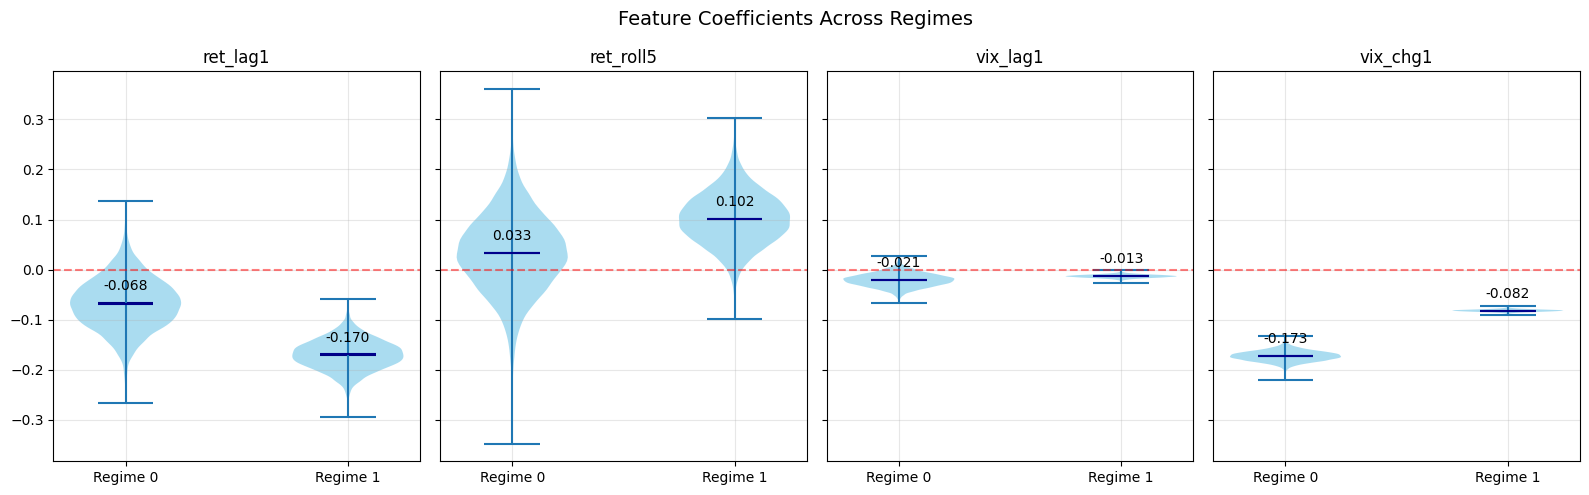

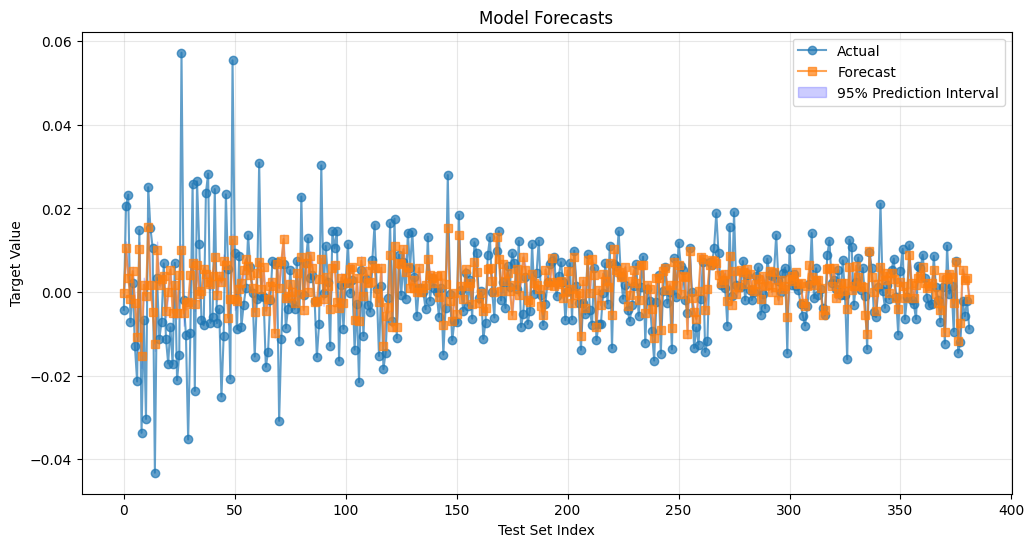

Test set metrics:
MSE: 0.000078
RMSE: 0.008813
MAE: 0.006292

Baseline model metrics:
MSE: 0.000073
RMSE: 0.008520
MAE: 0.005957

Change-point model improves MSE by -7.01% compared to baseline


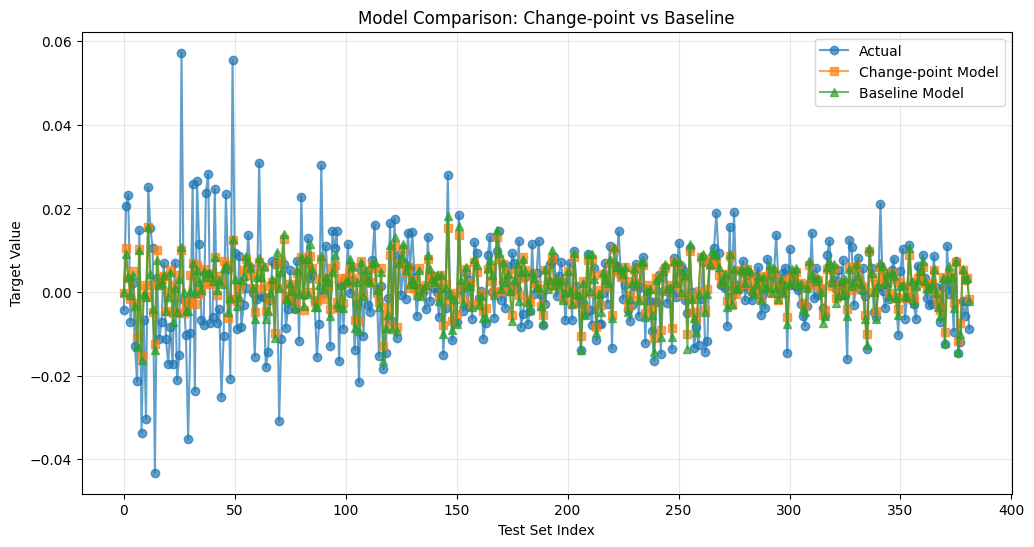

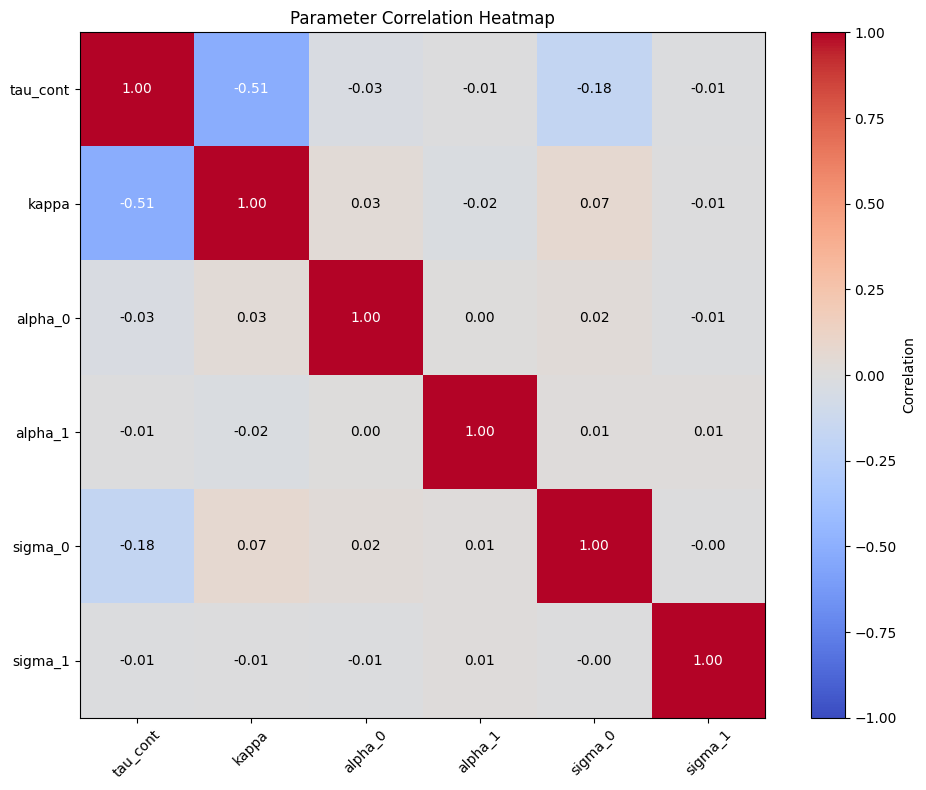

In [15]:
# Cell 1: Visualize feature coefficients across regimes
import matplotlib.pyplot as plt
import arviz as az
import numpy as np
import pandas as pd

# Create a coefficient comparison plot
def plot_regime_coefficients(trace, feature_cols):
    """Plot the comparison of feature coefficients across regimes"""
    fig, ax = plt.subplots(1, len(feature_cols), figsize=(16, 5), sharey=True)
    
    for i, feature in enumerate(feature_cols):
        # Extract coefficient samples for both regimes
        coef0 = trace.posterior['betas_0'].values[:, :, i].flatten()
        coef1 = trace.posterior['betas_1'].values[:, :, i].flatten()
        
        # Create violin plots
        parts = ax[i].violinplot([coef0, coef1], showmeans=True, showmedians=True)
        
        # Set colors
        for pc in parts['bodies']:
            pc.set_facecolor('skyblue')
            pc.set_alpha(0.7)
        
        parts['cmeans'].set_color('navy')
        parts['cmedians'].set_color('darkblue')
        
        # Add feature name as title
        ax[i].set_title(f'{feature}', fontsize=12)
        ax[i].set_xticks([1, 2])
        ax[i].set_xticklabels(['Regime 0', 'Regime 1'])
        ax[i].grid(True, alpha=0.3)
        
        # Add horizontal line at y=0
        ax[i].axhline(y=0, color='red', linestyle='--', alpha=0.5)
        
        # Add mean values as text
        ax[i].text(1, np.mean(coef0) + 0.02, f"{np.mean(coef0):.3f}", 
                   ha='center', va='bottom', fontsize=10)
        ax[i].text(2, np.mean(coef1) + 0.02, f"{np.mean(coef1):.3f}", 
                   ha='center', va='bottom', fontsize=10)
    
    fig.suptitle('Feature Coefficients Across Regimes', fontsize=14)
    plt.tight_layout()
    plt.show()

# Call this function with your trace and feature columns
plot_regime_coefficients(trace, feature_cols)


# Cell 3: Forecasting function and evaluation
def forecast_with_cp_model(model, trace, X_new, y_true=None):
    """
    Generate forecasts using the change-point model and calculate metrics if true values provided
    
    Parameters:
    -----------
    model : PyMC model
    trace : InferenceData object
    X_new : array-like, shape (n_samples, n_features)
        New feature data for forecasting
    y_true : array-like, optional
        True target values for evaluation
        
    Returns:
    --------
    dict : Dictionary with forecasts and evaluation metrics
    """
    with model:
        # Extract parameter posterior samples
        alpha_0_samples = trace.posterior['alpha_0'].values.flatten()
        alpha_1_samples = trace.posterior['alpha_1'].values.flatten()
        betas_0_samples = trace.posterior['betas_0'].values.reshape(-1, X_new.shape[1])
        betas_1_samples = trace.posterior['betas_1'].values.reshape(-1, X_new.shape[1])
        sigma_0_samples = trace.posterior['sigma_0'].values.flatten()
        sigma_1_samples = trace.posterior['sigma_1'].values.flatten()
        tau_samples = trace.posterior['tau_cont'].values.flatten()
        kappa_samples = trace.posterior['kappa'].values.flatten()
        
        # Calculate forecasts using posterior samples
        n_samples = len(alpha_0_samples)
        n_obs = len(X_new)
        forecasts = np.zeros((n_samples, n_obs))
        
        for i in range(n_samples):
            # For test data, we need to determine which regime it belongs to
            # Assuming test data follows training data, we can use the position 
            # relative to tau to calculate weights
            
            # Get sample i parameters
            alpha_0 = alpha_0_samples[i]
            alpha_1 = alpha_1_samples[i]
            betas_0 = betas_0_samples[i]
            betas_1 = betas_1_samples[i]
            tau = tau_samples[i]
            kappa = kappa_samples[i]
            
            # Calculate forecasts for each test observation
            # For simplicity, assume test observations continue from train indices
            for j in range(n_obs):
                # Calculate regime weight (assuming test data continues from training)
                # idx is relative to the end of training data
                idx = tau + j  # This places test data after training
                w_t = 1 / (1 + np.exp(-(idx - tau) / kappa))
                
                # Calculate predictions for both regimes
                mu0 = alpha_0 + np.dot(X_new[j], betas_0)
                mu1 = alpha_1 + np.dot(X_new[j], betas_1)
                
                # Weighted combination of regimes
                forecasts[i, j] = (1 - w_t) * mu0 + w_t * mu1
    
    # Calculate mean forecast and prediction intervals
    mean_forecast = np.mean(forecasts, axis=0)
    lower_bound = np.percentile(forecasts, 2.5, axis=0)
    upper_bound = np.percentile(forecasts, 97.5, axis=0)
    
    # Create results dictionary
    results = {
        'mean_forecast': mean_forecast,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'all_forecasts': forecasts
    }
    
    # Calculate metrics if true values are provided
    if y_true is not None:
        mse = np.mean((mean_forecast - y_true) ** 2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(mean_forecast - y_true))
        
        results['mse'] = mse
        results['rmse'] = rmse
        results['mae'] = mae
        
        # Add actual vs. predicted plot
        plt.figure(figsize=(12, 6))
        plt.plot(range(len(y_true)), y_true, 'o-', label='Actual', alpha=0.7)
        plt.plot(range(len(mean_forecast)), mean_forecast, 's-', label='Forecast', alpha=0.7)
        plt.fill_between(range(len(mean_forecast)), lower_bound, upper_bound, 
                         color='blue', alpha=0.2, label='95% Prediction Interval')
        plt.title(f'Model Forecasts')
        plt.xlabel('Test Set Index')
        plt.ylabel('Target Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    return results


# Cell 4: Apply forecast function to test data
# Prepare test data
X_test = df_test[feature_cols].values
y_test = df_test['y'].values


# Generate forecasts and evaluate
forecast_results = forecast_with_cp_model(model, trace, X_test, y_test)

print(f"Test set metrics:")
print(f"MSE: {forecast_results['mse']:.6f}")
print(f"RMSE: {forecast_results['rmse']:.6f}")
print(f"MAE: {forecast_results['mae']:.6f}")


# Cell 5: Compare with a simpler baseline model (optional)
from sklearn.linear_model import LinearRegression

# Train a simple linear regression model on training data
baseline_model = LinearRegression()
baseline_model.fit(df_train[feature_cols].values, df_train['y'].values)

# Make predictions on test data
baseline_preds = baseline_model.predict(df_test[feature_cols].values)

# Calculate metrics
baseline_mse = np.mean((baseline_preds - y_test) ** 2)
baseline_rmse = np.sqrt(baseline_mse)
baseline_mae = np.mean(np.abs(baseline_preds - y_test))

print("\nBaseline model metrics:")
print(f"MSE: {baseline_mse:.6f}")
print(f"RMSE: {baseline_rmse:.6f}")
print(f"MAE: {baseline_mae:.6f}")

# Compare with change-point model
improvement_pct = ((baseline_mse - forecast_results['mse']) / baseline_mse) * 100

print(f"\nChange-point model improves MSE by {improvement_pct:.2f}% compared to baseline")

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, 'o-', label='Actual', alpha=0.7)
plt.plot(range(len(forecast_results['mean_forecast'])), 
         forecast_results['mean_forecast'], 's-', label='Change-point Model', alpha=0.7)
plt.plot(range(len(baseline_preds)), baseline_preds, '^-', label='Baseline Model', alpha=0.7)
plt.title('Model Comparison: Change-point vs Baseline')
plt.xlabel('Test Set Index')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# Cell 6: Generate a heatmap of parameter correlations (optional)
def plot_parameter_correlations(trace):
    """Plot a correlation heatmap of key parameters"""
    # Extract parameters
    params = {
        'tau_cont': trace.posterior['tau_cont'].values.flatten(),
        'kappa': trace.posterior['kappa'].values.flatten(),
        'alpha_0': trace.posterior['alpha_0'].values.flatten(),
        'alpha_1': trace.posterior['alpha_1'].values.flatten(),
        'sigma_0': trace.posterior['sigma_0'].values.flatten(),
        'sigma_1': trace.posterior['sigma_1'].values.flatten()
    }
    
    # Create DataFrame
    df_params = pd.DataFrame(params)
    
    # Calculate correlation matrix
    corr_matrix = df_params.corr()
    
    # Plot heatmap
    plt.figure(figsize=(10, 8))
    plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    
    # Add correlation values
    for i in range(len(corr_matrix)):
        for j in range(len(corr_matrix)):
            plt.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}", 
                     ha='center', va='center', 
                     color='white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black')
    
    # Add labels
    plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=45)
    plt.yticks(range(len(corr_matrix)), corr_matrix.index)
    
    plt.colorbar(label='Correlation')
    plt.title('Parameter Correlation Heatmap')
    plt.tight_layout()
    plt.show()

# Call this function with your trace
plot_parameter_correlations(trace)

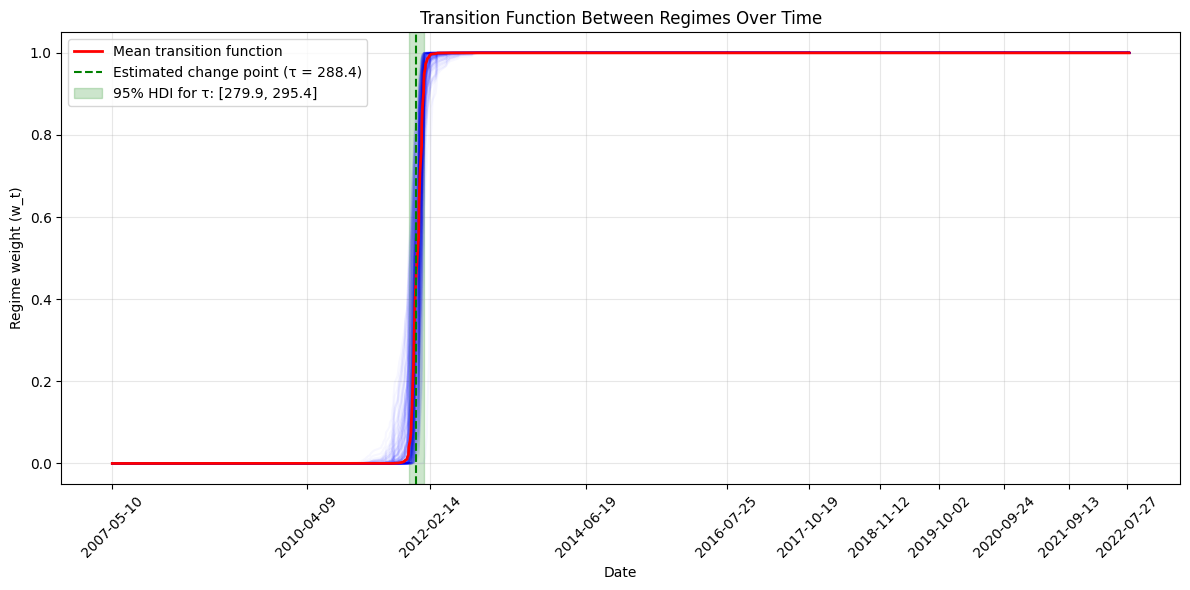

In [16]:
# Cell 2: Visualize the transition function over time
def plot_transition_function(trace, df):
    """Plot the transition function (w_t) over time to visualize the change-point"""
    # Extract posterior samples
    tau_samples = trace.posterior['tau_cont'].values.flatten()
    kappa_samples = trace.posterior['kappa'].values.flatten()
    
    # Create time index
    idx = np.arange(len(df))
#     dates   = df.index  # datetime index
    
    # Calculate w_t for mean parameter values
    tau_mean = np.mean(tau_samples)
    kappa_mean = np.mean(kappa_samples)
    w_t_mean = 1 / (1 + np.exp(-(idx - tau_mean) / kappa_mean))
    
    # Calculate w_t for multiple posterior samples (for uncertainty)
    n_samples = 200
    random_indices = np.random.choice(len(tau_samples), size=n_samples, replace=False)
    w_t_samples = np.zeros((n_samples, len(idx)))
    
    for i, sample_idx in enumerate(random_indices):
        tau = tau_samples[sample_idx]
        kappa = kappa_samples[sample_idx]
        w_t_samples[i, :] = 1 / (1 + np.exp(-(idx - tau) / kappa))

        # Convert index to datetime if not already
    dates = pd.to_datetime(df.index)

    # Plot setup
    plt.figure(figsize=(12, 6))

    # Plot samples
    for i in range(n_samples):
        plt.plot(dates, w_t_samples[i, :], color='blue', alpha=0.03)

    # Plot mean
    plt.plot(dates, w_t_mean, color='red', linewidth=2, label='Mean transition function')

    # Plot change point and HDI
    plt.axvline(x=dates[int(tau_mean)], color='green', linestyle='--',
                label=f'Estimated change point (τ = {tau_mean:.1f})')
    tau_hdi = az.hdi(tau_samples)
    plt.axvspan(dates[int(tau_hdi[0])], dates[int(tau_hdi[1])], alpha=0.2, color='green',
                label=f'95% HDI for τ: [{tau_hdi[0]:.1f}, {tau_hdi[1]:.1f}]')

    # Set datetime ticks properly
    step = max(len(dates) // 10, 1)
    xtick_dates = dates[::step]
    plt.xticks(ticks=xtick_dates, labels=[d.strftime('%Y-%m-%d') for d in xtick_dates], rotation=45)

    # Labels and layout
    plt.xlabel('Date')
    plt.ylabel('Regime weight (w_t)')
    plt.title('Transition Function Between Regimes Over Time')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    
#     # Plot
#     plt.figure(figsize=(12, 6))
    
#     # Plot individual samples with low alpha for uncertainty visualization
#     for i in range(n_samples):
#         plt.plot(dates, w_t_samples[i, :], color='blue', alpha=0.03)
    
#     # Plot mean w_t
#     plt.plot(dates, w_t_mean, color='red', linewidth=2, label='Mean transition function')
    
#     # Add vertical line at tau_mean
#     plt.axvline(x=tau_mean, color='green', linestyle='--', 
#                 label=f'Estimated change point (τ = {tau_mean:.1f})')
    
#     # Add uncertainty interval for tau
#     tau_hdi = az.hdi(tau_samples)
#     plt.axvspan(tau_hdi[0], tau_hdi[1], alpha=0.2, color='green',
#                 label=f'95% HDI for τ: [{tau_hdi[0]:.1f}, {tau_hdi[1]:.1f}]')
    
#     # Formatting
#     plt.xlabel('Observation index')
#     plt.ylabel('Regime weight (w_t)')
#     plt.title('Transition Function Between Regimes Over Time')
#     plt.grid(True, alpha=0.3)
#     # Limit the number of xticks to reduce overlap
#    # Reduce x-axis label overlap by showing only some dates
#     dates = pd.to_datetime(df.index)  # ensure it's in datetime format

#     step = max(len(dates) // 10, 1)  # adjust to show ~10 ticks
#     xtick_dates = dates[::step]
#     xtick_labels = [d.strftime('%Y-%m-%d') for d in xtick_dates]
#     plt.xticks(ticks=xtick_dates, labels=xtick_labels, rotation=45)

#     plt.legend()
#     plt.show()
# Ensure datetime format




# Call this function with your trace and data
plot_transition_function(trace, df_train)



In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1) Draw posterior predictive samples (InferenceData)
with model:
    ppc_train = pm.sample_posterior_predictive(
        trace,
        var_names=['y_obs']
    )

# 2) Extract the DataArray of y_obs samples
#    shape: (chain, draw, n_train)
y_ppc = ppc_train.posterior_predictive['y_obs']

# 3) Compute mean forecast per timepoint by averaging over chains & draws
#    result: 1D array of length n_train
y_pred_train = y_ppc.mean(dim=('chain','draw')).values

# 4) True in‐sample targets
y_train = df_train['y'].values

# 5) Compute metrics
mae_train  = mean_absolute_error(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

print(f"In‐sample MAE: {mae_train:.4f}, RMSE: {rmse_train:.4f}")


Sampling: [y_obs]


In‐sample MAE: 0.0077, RMSE: 0.0137


In [18]:
with model:
    ppc = pm.sample_posterior_predictive(
        trace,
        var_names=['y_obs'],
        random_seed=42  # do NOT set return_inferencedata=False
    )

# Extract DataArray
y_ppc = ppc.posterior_predictive['y_obs']

# Compute posterior mean over chains and draws
y_pred_mean = y_ppc.mean(dim=('chain', 'draw')).values

# Compute metrics
y_true = df_train['y'].values
mse  = np.mean((y_true - y_pred_mean)**2)
rmse = np.sqrt(mse)
print(f"Post-pred MSE:  {mse:.4f}")
print(f"Post-pred RMSE: {rmse:.4f}")


Sampling: [y_obs]


Post-pred MSE:  0.0002
Post-pred RMSE: 0.0137


In [19]:
y_true

array([-0.00726845,  0.02189117,  0.00400886, ...,  0.01563848,
       -0.00077734, -0.00286128])

In [20]:
y_ppc

<xarray.DataArray 'y_obs' (chain: 4, draw: 4000, y_obs_dim_2: 1526)>
array([[[ 0.00564507,  0.02341053,  0.00486629, ...,  0.02494145,
         -0.00056116,  0.00260806],
        [-0.00996618,  0.03879448,  0.02345862, ...,  0.02239985,
          0.01929624, -0.00980735],
        [-0.04773702, -0.01424818, -0.03804197, ...,  0.01590728,
         -0.01878554,  0.00558079],
        ...,
        [-0.01068107,  0.01029427,  0.00329145, ...,  0.01453444,
         -0.00127017, -0.00863112],
        [-0.04746861, -0.01210544, -0.01475768, ...,  0.01143315,
          0.01499006,  0.00483077],
        [-0.0057768 ,  0.02696614, -0.06023006, ...,  0.03172492,
          0.0011047 , -0.01013977]],

       [[-0.0270182 ,  0.02105933,  0.01034423, ...,  0.02431062,
          0.0154507 , -0.00339496],
        [-0.0186024 ,  0.03302123,  0.04010517, ...,  0.00366373,
          0.00081569,  0.00933137],
        [ 0.00346332, -0.03801678, -0.01062453, ...,  0.02792348,
          0.01517295,  0.00897482],
...
        [ 0.00238573, -0.00038686, -0.04365556, ..., -0.00496422,
         -0.00207346,  0.01055482],
        [ 0.01785661,  0.03104805, -0.00667762, ...,  0.00378193,
         -0.00191574, -0.00237754],
        [-0.00170369, -0.00619286, -0.01645235, ...,  0.00877803,
          0.0001986 ,  0.00624865]],

       [[ 0.02942101,  0.00626586, -0.00429893, ...,  0.01940583,
          0.00197959, -0.00179761],
        [ 0.02562377,  0.00227354,  0.02520609, ...,  0.00721573,
         -0.00094841, -0.0059402 ],
        [-0.01260796,  0.0404965 , -0.00661847, ...,  0.00797187,
          0.01127952,  0.01016876],
        ...,
        [-0.00393309, -0.01146802, -0.00673559, ...,  0.00738511,
          0.00794503,  0.00901095],
        [-0.03414193,  0.01821689,  0.00535321, ...,  0.00955061,
         -0.01156693, -0.00292586],
        [ 0.01628751,  0.00095086, -0.0022301 , ...,  0.00947603,
         -0.00267817,  0.00911566]]])
Coordinates:
  * chain        (chain) int64 0 1 2 3
  * draw         (draw) int64 0 1 2 3 4 5 6 ... 3994 3995 3996 3997 3998 3999
  * y_obs_dim_2  (y_obs_dim_2) int64 0 1 2 3 4 5 ... 1521 1522 1523 1524 1525

In [21]:
print("Index dtype:", df_train.index.dtype)
print("First few index values:", df_train.index[:5])

Index dtype: object
First few index values: Index(['2007-05-10', '2007-05-22', '2007-05-30', '2007-07-13', '2007-07-18'], dtype='object')


In [22]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1526 entries, 2007-05-10 to 2022-08-08
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     1526 non-null   object 
 1   close_sp500              1526 non-null   float64
 2   close_vix                1526 non-null   float64
 3   polarity_x_strong        1526 non-null   float64
 4   y                        1526 non-null   float64
 5   ret_lag1                 1526 non-null   float64
 6   ret_roll5                1526 non-null   float64
 7   vix_lag1                 1526 non-null   float64
 8   vix_chg1                 1526 non-null   float64
 9   polarity_x_strong_lag1   1526 non-null   float64
 10  polarity_x_strong_roll3  1526 non-null   float64
 11  sent_roll3_std           1526 non-null   float64
 12  vix_chg1_std             1526 non-null   float64
 13  sent_vix                 1526 non-null   float64
dtypes: float64(13)

In [23]:
# Convert the column to datetime if you haven’t already
df_train['date'] = pd.to_datetime(df_train['date'])

# Now set it as the single index
df_train = df_train.set_index('date')

# (Optionally) drop the old index name, just for clarity
df_train.index.name = None

# Confirm
print("New index dtype:", df_train.index.dtype)
print(df_train.head())

New index dtype: datetime64[ns]
            close_sp500  close_vix  polarity_x_strong         y  ret_lag1  \
2007-05-10  1491.469971      13.60           0.000000 -0.007268  0.010826   
2007-05-22  1524.119995      13.06           0.999803  0.021891 -0.007268   
2007-05-30  1530.229980      12.83           0.917965  0.004009  0.021891   
2007-07-13  1552.500000      15.15           0.000000  0.014553  0.004009   
2007-07-18  1546.170044      16.00           0.000000 -0.004077  0.014553   

            ret_roll5  vix_lag1  vix_chg1  polarity_x_strong_lag1  \
2007-05-10   0.007889 -0.031088  0.038961                0.999995   
2007-05-22   0.003151  0.038961 -0.039706                0.000000   
2007-05-30   0.007203 -0.039706 -0.017611                0.999803   
2007-07-13   0.006422 -0.017611  0.180826                0.917965   
2007-07-18   0.008802  0.180826  0.056106                0.000000   

            polarity_x_strong_roll3  sent_roll3_std  vix_chg1_std  sent_vix  
2007-05-10  

In [93]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1526 entries, 2007-05-10 to 2022-08-08
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   close_sp500              1526 non-null   float64
 1   close_vix                1526 non-null   float64
 2   polarity_x_strong        1526 non-null   float64
 3   y                        1526 non-null   float64
 4   ret_lag1                 1526 non-null   float64
 5   ret_roll5                1526 non-null   float64
 6   vix_lag1                 1526 non-null   float64
 7   vix_chg1                 1526 non-null   float64
 8   polarity_x_strong_lag1   1526 non-null   float64
 9   polarity_x_strong_roll3  1526 non-null   float64
 10  sent_roll3_std           1526 non-null   float64
 11  vix_chg1_std             1526 non-null   float64
 12  sent_vix                 1526 non-null   float64
dtypes: float64(13)
memory usage: 166.9+ KB


In [24]:
import numpy as np
import arviz as az

# Flatten the posterior samples of tau_cont
tau_samps = trace.posterior['tau_cont'].stack(
    samples=("chain","draw")
).values  # shape (n_samples,)

# Compute mean index and 95% HDI
mean_idx   = tau_samps.mean()
hdi_bounds = az.hdi(tau_samps, hdi_prob=0.95)  # returns [lower, upper]
lower_idx, upper_idx = hdi_bounds

# Round to nearest integer positions
mean_pos  = int(np.round(mean_idx))
lower_pos = int(np.round(lower_idx))
upper_pos = int(np.round(upper_idx))

# Now index into the datetime index to get real dates
mean_date      = df_train.index[mean_pos]
hdi_lower_date = df_train.index[lower_pos]
hdi_upper_date = df_train.index[upper_pos]

print(f"Estimated change‐point ≃ {mean_date}")
print(f"95% HDI: {hdi_lower_date} – {hdi_upper_date}")

Estimated change‐point ≃ 2011-11-30 00:00:00
95% HDI: 2011-10-20 00:00:00 – 2012-01-10 00:00:00


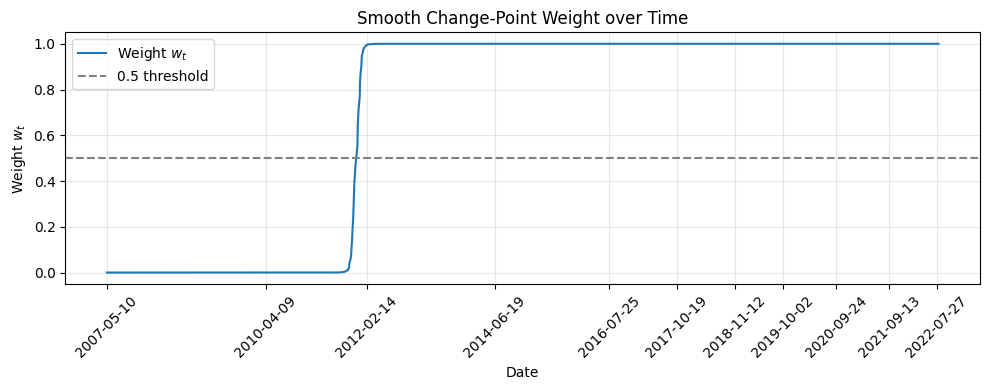

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Prepare data & posterior samples
n_obs = len(df_train)
dates = pd.to_datetime(df_train.index)  # make sure these are true datetimes

tau_samps = trace.posterior['tau_cont'] \
    .stack(samples=("chain","draw")) \
    .values
kappa_samps = trace.posterior['kappa'] \
    .stack(samples=("chain","draw")) \
    .values

# 2) Compute the smooth weight
idx = np.arange(n_obs)
w = 1 / (1 + np.exp(-(idx - np.mean(tau_samps)) / np.mean(kappa_samps)))

# 3) Plot on a single Axes
fig, ax = plt.subplots(figsize=(10, 4))

# plot the weight curve
ax.plot(dates, w, label='Weight $w_t$')

# optional horizontal reference line
ax.axhline(0.5, ls='--', color='gray', label='0.5 threshold')

# 4) Reduce x‑axis label clutter
step = max(len(dates) // 10, 1)
xtick_dates = dates[::step]
xtick_labels = [d.strftime('%Y-%m-%d') for d in xtick_dates]

ax.set_xticks(xtick_dates)
ax.set_xticklabels(xtick_labels, rotation=45)

# 5) Final formatting
ax.set_title("Smooth Change‑Point Weight over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Weight $w_t$")
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()


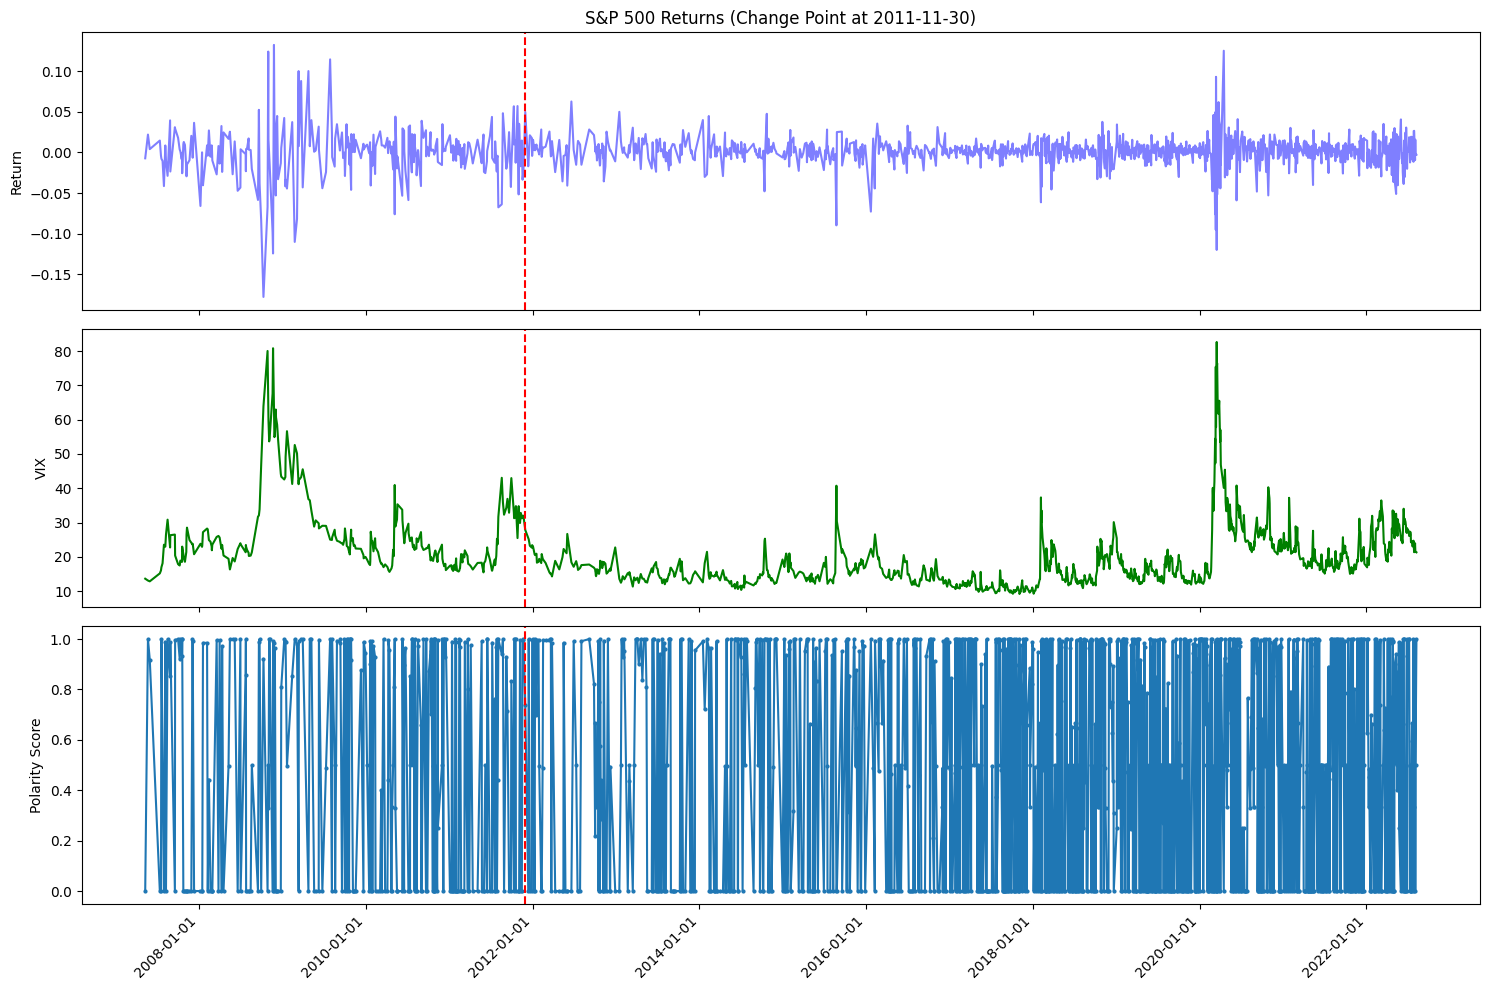

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1) Make sure your index is real datetime
df_train.index = pd.to_datetime(df_train.index)

# 2) Compute mean change‑point position & date
tau_samps = trace.posterior['tau_cont'].stack(samples=("chain","draw")).values
mean_tau   = np.mean(tau_samps)
mean_pos   = int(np.round(mean_tau))
mean_date  = df_train.index[mean_pos]

# 3) Set up 3‑panel plot, sharing x‑axis
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

# Panel 1: y
axes[0].plot(df_train.index, df_train['y'],   'b-', alpha=0.5)
axes[0].set_ylabel('Return')
axes[0].set_title(f'S&P 500 Returns (Change Point at {mean_date.date()})')

# Panel 2: VIX
axes[1].plot(df_train.index, df_train['close_vix'], 'g-')
axes[1].set_ylabel('VIX')

# Panel 3: Polarity
axes[2].plot(df_train.index, df_train['polarity_x_strong'], 'o-', markersize=2)
axes[2].set_ylabel('Polarity Score')

# 4) Draw the change‑point line on each panel
for ax in axes:
    ax.axvline(mean_date, color='r', linestyle='--')

# 5) Enable a proper datetime axis on the bottom
axes[-1].xaxis.set_major_locator(mdates.AutoDateLocator())
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.setp(axes[-1].get_xticklabels(), rotation=45, ha='right')

# Final layout  
plt.tight_layout()
plt.show()


In [24]:
df_test

,title,text,label,published_day,published_day_str,^GSPC_close,^VIX_close,sentiment,score,sentiment_numeric,date,sp500_ret,y,ret_lag1,ret_roll5,vix_lag1,vix_chg1,sent_lag1,sent_roll3
3336,Stocks making the biggest moves in the premark...,Take a look at some of the biggest movers in t...,-2,2023-11-06,2023-11-06,4365.979980,14.890000,positive,0.976168,0.976168,2023-11-06,0.000000,0.000000,-0.030431,-0.005501,-0.485806,-0.035536,-1.083597,-1.510745
3337,"Stocks Slide, Led by Industrials; CAT Falls",Stocks traded sharply lower amid worries over ...,0,2023-11-06,2023-11-06,4365.979980,14.890000,positive,0.999934,0.999934,2023-11-06,0.000000,0.002840,-0.030431,-0.005501,-0.485806,-0.035536,1.837090,-0.194955
3338,Here are Tuesday's biggest analyst calls of th...,Here are the biggest calls on Wall Street on T...,0,2023-11-07,2023-11-07,4378.379883,14.810000,neutral,0.999855,0.099986,2023-11-07,0.002840,0.000000,-0.030431,-0.005501,-0.485806,-0.035536,1.872369,1.490404
3339,Ulta Beauty strikes deal to open hundreds of s...,Target has struck a deal with Ulta Beauty to o...,2,2023-11-07,2023-11-07,4378.379883,14.810000,negative,0.996685,-0.996685,2023-11-07,0.000000,0.001005,0.198697,0.108357,-0.496301,-0.100960,0.536490,2.410266
3340,US stock futures hold lower after economic dat...,U.S. stock index futures traded lower on Thurs...,-1,2023-11-08,2023-11-08,4382.779785,14.450000,neutral,0.767421,0.076742,2023-11-08,0.001005,0.000000,-0.030431,0.038081,-0.496301,-0.035536,-1.091400,0.747512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4165,4 economic reports the market cares about most...,"Wall Street ended the week lower, despite the ...",-2,2024-04-19,2024-04-19,4967.229980,18.709999,positive,0.989432,0.989432,2024-04-19,0.000000,0.000000,-0.030431,-0.075777,0.015317,-0.035536,0.534187,-0.020464
4166,Cramer: eBay's results boost investment case f...,CNBC's Jim Cramer said Wednesday that eBay 's ...,-2,2024-04-19,2024-04-19,4967.229980,18.709999,positive,0.999985,0.999985,2024-04-19,0.000000,0.000000,-0.030431,-0.075777,0.015317,-0.035536,1.856779,0.735838
4167,Stocks on the Move Now,Shares of the following companies are showing ...,2,2024-04-19,2024-04-19,4967.229980,18.709999,neutral,0.999331,0.099933,2024-04-19,0.000000,0.000000,-0.030431,-0.075777,0.015317,-0.035536,1.872445,2.420180
4168,Here's how much money you'd have if you invest...,A Costco Wholesale warehouse sign is seen outs...,-2,2024-04-19,2024-04-19,4967.229980,18.709999,negative,0.999984,-0.999984,2024-04-19,0.000000,0.000000,-0.030431,-0.075777,0.015317,-0.035536,0.536413,2.421444


In [27]:
import numpy as np
import arviz as az
from sklearn.metrics import mean_absolute_error, mean_squared_error

# —————————————————————————————————
# 1. Extract posterior draws
# —————————————————————————————————


post = trace.posterior.stack(samples=("chain", "draw"))
tau_samps    = post['tau_cont'].values
kappa_samps  = post['kappa'].values
alpha0_samps = post['alpha_0'].values
alpha1_samps = post['alpha_1'].values
sigma0_samps = post['sigma_0'].values
sigma1_samps = post['sigma_1'].values
betas0_samps = post['betas_0'].values
betas1_samps = post['betas_1'].values

X_test = df_test[feature_cols].values
actual_y = df_test['y'].values

n_samps = tau_samps.shape[0]
n_test  = len(df_test)

# Ensure (n_samps, n_features)
if betas0_samps.shape[0] != tau_samps.shape[0]:
    betas0_samps = betas0_samps.T
    betas1_samps = betas1_samps.T

print("beta0 shape after: ", betas0_samps.shape)  # should be (n_samps, n_features)

# —————————————————————————————————
# 2. Build global indices
# —————————————————————————————————
idx_full = np.arange(len(df_train) + n_test)
idx_test = idx_full[len(df_train):]

# —————————————————————————————————
# 3. Compute smooth‐CP weights
# —————————————————————————————————
num    = idx_test[None, :] - tau_samps[:, None]
w_test = 1 / (1 + np.exp(- num / kappa_samps[:, None]))

# —————————————————————————————————
# 4. Compute regime means & volatilities
# —————————————————————————————————
mu0_test = alpha0_samps[:, None] + betas0_samps @ X_test.T
mu1_test = alpha1_samps[:, None] + betas1_samps @ X_test.T

mu_test    = (1 - w_test) * mu0_test + w_test * mu1_test
sigma_test = (1 - w_test) * sigma0_samps[:, None] + w_test * sigma1_samps[:, None]

# —————————————————————————————————
# 5. Draw posterior predictive samples
# —————————————————————————————————
y_pred_samples = np.random.normal(mu_test, sigma_test)

# —————————————————————————————————
# 6. Summarize & evaluate
# —————————————————————————————————
y_pred_mean = y_pred_samples.mean(axis=0)
hdi_bounds  = az.hdi(y_pred_samples, hdi_prob=0.94)

mae      = mean_absolute_error(actual_y, y_pred_mean)
rmse     = np.sqrt(mean_squared_error(actual_y, y_pred_mean))
coverage = np.mean((actual_y >= hdi_bounds[:, 0]) & (actual_y <= hdi_bounds[:, 1]))

print(f"Out-of-sample MAE: {mae:.4f}")
print(f"Out-of-sample RMSE: {rmse:.4f}")
print(f"94% interval coverage: {coverage:.2%}")


beta0 shape after:  (16000, 4)


/var/folders/_d/9s0yylrd6jqb1fngnlzw7nl40000gn/T/ipykernel_55883/2796312740.py:63: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_bounds  = az.hdi(y_pred_samples, hdi_prob=0.94)


Out-of-sample MAE: 0.0063
Out-of-sample RMSE: 0.0089
94% interval coverage: 96.86%


In [115]:
def predict_with_cp_model(trace, X_new, feature_cols):
    """
    Make predictions using the fitted Bayesian change-point model.
    
    Parameters:
    -----------
    trace : InferenceData
        The posterior samples from MCMC
    X_new : DataFrame or array
        New features for prediction
    feature_cols : list
        Feature column names (if X_new is DataFrame)
        
    Returns:
    --------
    dict : Dictionary with prediction mean and intervals
    """
    import numpy as np
    
    # Prepare features
    if isinstance(X_new, pd.DataFrame):
        X_pred = X_new[feature_cols].values
    else:
        X_pred = X_new
    
    # Extract posterior samples
    posterior = trace.posterior
    
    # Storage for predictions
    n_samples = len(posterior.chain) * len(posterior.draw)
    all_preds = np.zeros((n_samples, len(X_pred)))
    
    # Since we're making predictions for future data, 
    # we use the post-change-point parameters
    sample_idx = 0
    for c in range(len(posterior.chain)):
        for d in range(len(posterior.draw)):
            # Extract post-change parameters
            alpha = float(posterior.alpha_1[c, d].values)
            betas = posterior.betas_1[c, d].values
            
            # Generate predictions
            for i, x in enumerate(X_pred):
                all_preds[sample_idx, i] = alpha + np.dot(x, betas)
                
            sample_idx += 1
    
    # Calculate summary statistics
    results = {
        'mean': np.mean(all_preds, axis=0),
        'median': np.median(all_preds, axis=0),
        'std': np.std(all_preds, axis=0),
        'lower_95': np.percentile(all_preds, 2.5, axis=0),
        'upper_95': np.percentile(all_preds, 97.5, axis=0)
    }
    
    return results

In [116]:
test_size = len(df_test)

test_df = df.iloc[-test_size:]   # Hold out recent data for testing
# Now predict on test data
test_X = test_df[feature_cols]
predictions = predict_with_cp_model(trace, test_X, feature_cols)

# Compare with actual values
actual = test_df['y'].values
print(f"Mean absolute error: {np.mean(np.abs(predictions['mean'] - actual))}")

Mean absolute error: 0.006328709837516106


You've got it! Let me explain the pipeline of this Bayesian change-point approach:

### 1. Model Building and Fitting Phase
In your existing `bayesian_cp_forecast` function:

- You define a probabilistic model with PyMC that includes:
  - A change-point parameter `tau` that follows a discrete uniform distribution
  - Two sets of regression parameters: one for before the change-point and one for after
  - A likelihood function that switches between the two parameter sets based on `tau`

- You run MCMC sampling (specifically NUTS - No U-Turn Sampler) to:
  - Explore the posterior distribution of all parameters
  - Jointly estimate where the change-point occurred and what the parameters are in each regime
  - Store all of these samples in the `trace` object, which contains thousands of plausible parameter combinations

- The function returns:
  - `model`: The PyMC model object that defines the structure
  - `trace`: The posterior samples for all parameters

### 2. Analysis and Interpretation
After fitting, you can:
- Visualize the posterior distribution of `tau` to see when the change likely occurred
- Examine the different regression coefficients to understand how relationships changed
- Compare volatility (`sigma_0` vs `sigma_1`) to see if market uncertainty changed

### 3. Prediction Phase
With the `predict_with_cp_model` function:

- You take new feature data that needs prediction
- You use the post-change-point parameters (since these represent the most recent regime)
- For each posterior sample (from thousands of MCMC draws), you:
  - Extract the parameter values (alpha_1, betas_1)
  - Calculate a prediction for the new data
  - This gives you thousands of plausible predictions based on different parameter combinations

- You summarize these predictions to get:
  - The mean prediction (central tendency)
  - Uncertainty intervals (95% credible intervals)
  - Standard deviation (prediction uncertainty)

The beauty of this Bayesian approach is that it fully accounts for uncertainty in:
1. The location of the change-point
2. The regression parameters in each regime
3. The resulting predictions

Rather than a single prediction value, you get an entire probability distribution of possible outcomes, which is particularly valuable in financial markets where understanding risk is crucial.

In [117]:
def plot_bayesian_cp_results(train_df, test_df, trace, feature_cols):
    """
    Plot actual vs predicted values for both training and test sets.
    
    Parameters:
    -----------
    train_df : DataFrame
        Training data with features and target
    test_df : DataFrame
        Test data with features and target
    trace : InferenceData
        Posterior samples from MCMC
    feature_cols : list
        Feature column names
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    
    # Predict on training data
    train_pred = predict_with_cp_model(trace, train_df[feature_cols], feature_cols)
    
    # Predict on test data
    test_pred = predict_with_cp_model(trace, test_df[feature_cols], feature_cols)
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot training data
    ax1.plot(train_df.index, train_df['y'], 'b-', label='Actual')
    ax1.plot(train_df.index, train_pred['mean'], 'r-', label='Predicted Mean')
    ax1.fill_between(
        train_df.index, 
        train_pred['lower_95'], 
        train_pred['upper_95'], 
        color='r', 
        alpha=0.2, 
        label='95% Credible Interval'
    )
    
    # Add change-point vertical line
    # tau_median = int(trace.posterior.tau.median().values)
    tau_median = int(trace.posterior['tau_cont'].median().values)

    change_date = train_df.index[tau_median]
    ax1.axvline(x=change_date, color='g', linestyle='--', label=f'Change Point: {change_date.date()}')
    
    ax1.set_title('Training Set: Actual vs Predicted Returns')
    ax1.legend()
    ax1.set_ylabel('Return')
    
    # Plot test data
    ax2.plot(test_df.index, test_df['y'], 'b-', label='Actual')
    ax2.plot(test_df.index, test_pred['mean'], 'r-', label='Predicted Mean')
    ax2.fill_between(
        test_df.index, 
        test_pred['lower_95'], 
        test_pred['upper_95'], 
        color='r', 
        alpha=0.2, 
        label='95% Credible Interval'
    )
    
    ax2.set_title('Test Set: Actual vs Predicted Returns')
    ax2.legend()
    ax2.set_ylabel('Return')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and print performance metrics
    train_mae = np.mean(np.abs(train_pred['mean'] - train_df['y']))
    test_mae = np.mean(np.abs(test_pred['mean'] - test_df['y']))
    
    print(f"Training MAE: {train_mae:.6f}")
    print(f"Test MAE: {test_mae:.6f}")
    
    # Create a results DataFrame
    # results_df = pd.DataFrame({
    #     'date': np.concatenate([train_df.index.values, test_df.index.values]),

    #     'actual': pd.concat([train_df['y'], test_df['y']]),
    #     'predicted': np.concatenate([train_pred['mean'], test_pred['mean']]),
    #     'lower_95': np.concatenate([train_pred['lower_95'], test_pred['lower_95']]),
    #     'upper_95': np.concatenate([train_pred['upper_95'], test_pred['upper_95']]),
    #     'set': ['train']*len(train_df) + ['test']*len(test_df)
    # })
    results_df = pd.DataFrame({
    'actual': pd.concat([train_df['y'], test_df['y']]),
    'predicted': np.concatenate([train_pred['mean'], test_pred['mean']]),
    'lower_95': np.concatenate([train_pred['lower_95'], test_pred['lower_95']]),
    'upper_95': np.concatenate([train_pred['upper_95'], test_pred['upper_95']]),
    'set': ['train']*len(train_df) + ['test']*len(test_df)
    }, index=pd.concat([train_df.index.to_series(), test_df.index.to_series()]))
    results_df.index.name = 'date'

    
    return results_df

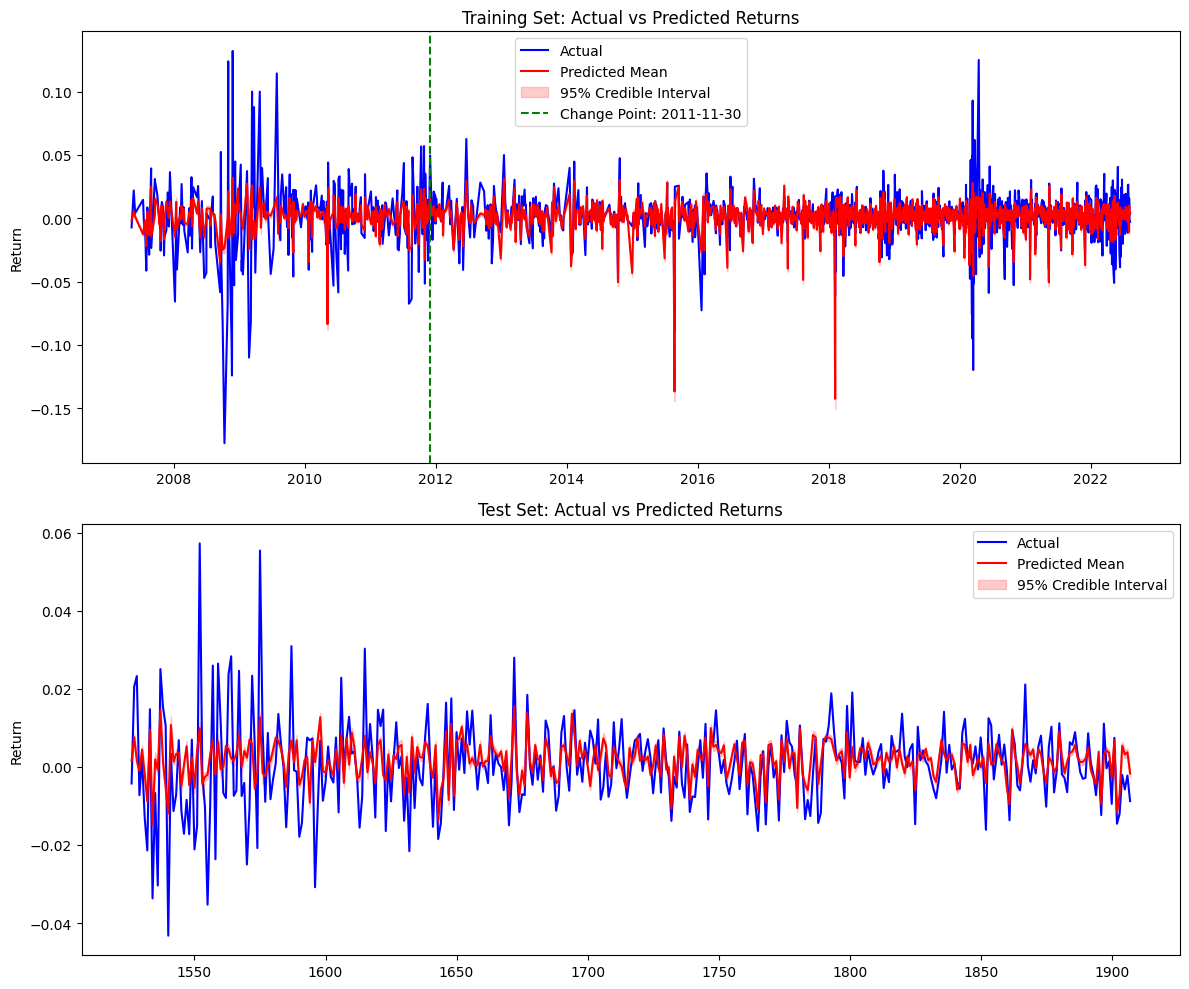

Training MAE: 0.008075
Test MAE: 0.006329


In [119]:
# Plot results and get results DataFrame
results_df = plot_bayesian_cp_results(df_train, df_test, trace, feature_cols)

In [46]:
def predict_with_cp_model(trace, X_new, feature_cols):
    """
    Make predictions using the fitted Bayesian change-point model.
    
    Parameters:
    -----------
    trace : InferenceData
        The posterior samples from MCMC
    X_new : DataFrame or array
        New features for prediction
    feature_cols : list
        Feature column names (if X_new is DataFrame)
        
    Returns:
    --------
    dict : Dictionary with prediction mean and intervals
    """
    import numpy as np
    
    # Prepare features
    if isinstance(X_new, pd.DataFrame):
        X_pred = X_new[feature_cols].values
    else:
        X_pred = X_new
    
    # Extract posterior samples
    posterior = trace.posterior
    
    # Storage for predictions
    n_samples = len(posterior.chain) * len(posterior.draw)
    all_preds = np.zeros((n_samples, len(X_pred)))
    
    # Since we're making predictions for future data, 
    # we use the post-change-point parameters
    sample_idx = 0
    for c in range(len(posterior.chain)):
        for d in range(len(posterior.draw)):
            # Extract post-change parameters
            alpha = float(posterior.alpha_1[c, d].values)
            betas = posterior.betas_1[c, d].values
            
            # Generate predictions
            for i, x in enumerate(X_pred):
                all_preds[sample_idx, i] = alpha + np.dot(x, betas)
                
            sample_idx += 1
    
    # Calculate summary statistics
    results = {
        'mean': np.mean(all_preds, axis=0),
        'median': np.median(all_preds, axis=0),
        'std': np.std(all_preds, axis=0),
        'lower_95': np.percentile(all_preds, 2.5, axis=0),
        'upper_95': np.percentile(all_preds, 97.5, axis=0)
    }
    
    return results

In [121]:
import numpy as np
import arviz as az
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- 1) In-sample vs Out-of-sample errors ---



# In-sample (training) forecast
train_pred = predict_with_cp_model(
    trace,
    df_train[feature_cols],
    feature_cols,
    # start_index=0
)

# Out-of-sample (test) forecast
test_pred = predict_with_cp_model(
    trace,
    df_test[feature_cols],
    feature_cols,
    # start_index=len(df_train)
)

y_train = df_train['y'].values
y_test  = df_test['y'].values

# Compute MAE & RMSE
mae_train  = mean_absolute_error(y_train, train_pred['mean'])
rmse_train = np.sqrt(mean_squared_error(y_train, train_pred['mean']))
mae_test   = mean_absolute_error(y_test,  test_pred['mean'])
rmse_test  = np.sqrt(mean_squared_error(y_test,  test_pred['mean']))

print("▶ In-sample vs Out-of-sample")
print(f"Train MAE: {mae_train:.4f}, Test MAE: {mae_test:.4f}, Ratio: {mae_test/mae_train:.2f}")
print(f"Train RMSE: {rmse_train:.4f}, Test RMSE: {rmse_test:.4f}, Ratio: {rmse_test/rmse_train:.2f}")

# A ratio ≫ 1 indicates potential over-fitting.

# --- 2) Bayesian LOO & WAIC (requires log_likelihood in idata) ---

# `idata` should be your InferenceData from `pm.sample(..., return_inferencedata=True)`
# with `idata = pm.sample_posterior_predictive(idata, ..., return_inferencedata=True)`
# so that `idata.log_likelihood.y_obs` exists.

# loo  = az.loo(idata, var_names=['y_obs'])
# waic = az.waic(idata, var_names=['y_obs'])

# print("\n▶ Bayesian model comparison")
# print(loo)
# print(waic)


# Lower LOO or WAIC suggests better out-of-sample predictive performance,
# trading off fit vs. complexity.


▶ In-sample vs Out-of-sample
Train MAE: 0.0081, Test MAE: 0.0063, Ratio: 0.78
Train RMSE: 0.0148, Test RMSE: 0.0089, Ratio: 0.60
